In [2]:

# IMPORTANT - This notebook is setup using a minumim speed of 5 and not using previous speed
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# vars
w0 = 5
pfe = 1
split = 0.8
use_previous_speed = False # True if use previous speed as feature
min_speed = 5
learning_rate = 0.0005
decay = 1e-7
num_epochs = 2000
np.random.seed(420)
paths = [
    'shell_1_strokes_2025-04-07.csv',
    'shell_2_strokes_2025-04-07.csv'
]


In [3]:
def process_df(path):
    # 3) Concatenate
    df = pd.read_csv(path)
    df = df.dropna()
    # 4.5 m/s = 1:51.1 per 500 --paddling
    # 4.75 = 1:45 -- "quality" steady rowing 
    # 5 is 1:40  -- medium rowing
    # 5.25 is 1:35 -- hard rowing
    # 5.5 is 1:31 -- Around base pace
    df = df[df['speed_mps'] > min_speed]
    
    new_features = []
    
    for stroke_num, same_stroke in df.groupby('crew_stroke_number'):
        # make sure we are getting data from more than half the boat
        if len(same_stroke) < 5: # this condition and in speed req filter out spinning drilling etc 
            continue
        features = {
            'crew_stroke_number':stroke_num,
            'ave_power':same_stroke['power_w'].mean(),
            'power_var':same_stroke['power_w'].var(),
            'rate_spm':same_stroke['rating_spm'].mean(),
            'ave_work':same_stroke['work_j'].mean(),
            'work_var':same_stroke['work_j'].var(),
            'catch_angle':same_stroke['catch_angle_deg'].mean(),
            'catch_angle_var':same_stroke['catch_angle_deg'].var(),
            'slip_angle':same_stroke['slip_deg'].mean(),
            'slip_var':same_stroke['slip_deg'].var(),
            'wash_angle':same_stroke['wash_deg'].mean(),
            'wash_var':same_stroke['wash_deg'].var(),
            'connected_angle':same_stroke['connected_length_deg'].mean(),
            'connected_var':same_stroke['connected_length_deg'].var(),
            'finish_angle':same_stroke['release_angle_deg'].mean(),
            'finish_angle_var':same_stroke['release_angle_deg'].var(),
            'peak_force_angle':same_stroke['peak_force_angle_deg'].mean(),
            'peak_force_angle_var':same_stroke['peak_force_angle_deg'].var(),
            'catch_time':same_stroke['catch_timestamp_ms'].mean(),
            'catch_time_var':same_stroke['catch_timestamp_ms'].var(),
            'stroke_duration':same_stroke['stroke_duration_ms'].mean(),
            'stroke_duration_var':same_stroke['stroke_duration_ms'].var(),
            'speed_mps':same_stroke['speed_mps'].mean(),
        }
        new_features.append(features)

    cleaned_df = pd.DataFrame.from_records(new_features)
    cleaned_df = cleaned_df.drop_duplicates(subset=['crew_stroke_number'])
    cleaned_df = cleaned_df.sort_values('crew_stroke_number').reset_index(drop=True)

    # use the speed from stroke n-1 to predict speed of stroke n
    if use_previous_speed:
        cleaned_df['speed_prev'] = cleaned_df['speed_mps'].shift(1)
        cleaned_df = cleaned_df.dropna(subset=['speed_prev'])

    # cube root power metrics
    cleaned_df['ave_power'] = np.cbrt(cleaned_df['ave_power'])
    cleaned_df['power_var'] = np.cbrt(cleaned_df['power_var'])
    cleaned_df['ave_work'] = np.cbrt(cleaned_df['ave_work'])
    cleaned_df['work_var'] = np.cbrt(cleaned_df['work_var'])

    df = cleaned_df
    # number data points
    print (f'Number of data points: {len(df)}')
    return df

df1 = process_df(paths[0])
df2 = process_df(paths[1])
df = pd.concat([df1, df2])

# sanity check on distance per stroke not being a feature b/c speed = distance/stroke * strokes/min
feature_cols = [
    col for col in df.columns if col not in ['crew_stroke_number', 'speed_mps', 'distance_per_stroke_m']]
target_col = 'speed_mps'

Number of data points: 570
Number of data points: 487


Epoch [50/2000], Loss: 0.0044
Epoch [100/2000], Loss: 0.0027
Epoch [150/2000], Loss: 0.0023
Epoch [200/2000], Loss: 0.0021
Epoch [250/2000], Loss: 0.0016
Epoch [300/2000], Loss: 0.0017
Epoch [350/2000], Loss: 0.0014
Epoch [400/2000], Loss: 0.0013
Epoch [450/2000], Loss: 0.0013
Epoch [500/2000], Loss: 0.0014
Epoch [550/2000], Loss: 0.0013
Epoch [600/2000], Loss: 0.0013
Epoch [650/2000], Loss: 0.0013
Epoch [700/2000], Loss: 0.0011
Epoch [750/2000], Loss: 0.0012
Epoch [800/2000], Loss: 0.0011
Epoch [850/2000], Loss: 0.0013
Epoch [900/2000], Loss: 0.0011
Epoch [950/2000], Loss: 0.0010
Epoch [1000/2000], Loss: 0.0011
Epoch [1050/2000], Loss: 0.0011
Epoch [1100/2000], Loss: 0.0010
Epoch [1150/2000], Loss: 0.0012
Epoch [1200/2000], Loss: 0.0011
Epoch [1250/2000], Loss: 0.0010
Epoch [1300/2000], Loss: 0.0011
Epoch [1350/2000], Loss: 0.0011
Epoch [1400/2000], Loss: 0.0011
Epoch [1450/2000], Loss: 0.0011
Epoch [1500/2000], Loss: 0.0011
Epoch [1550/2000], Loss: 0.0010
Epoch [1600/2000], Loss: 0.0

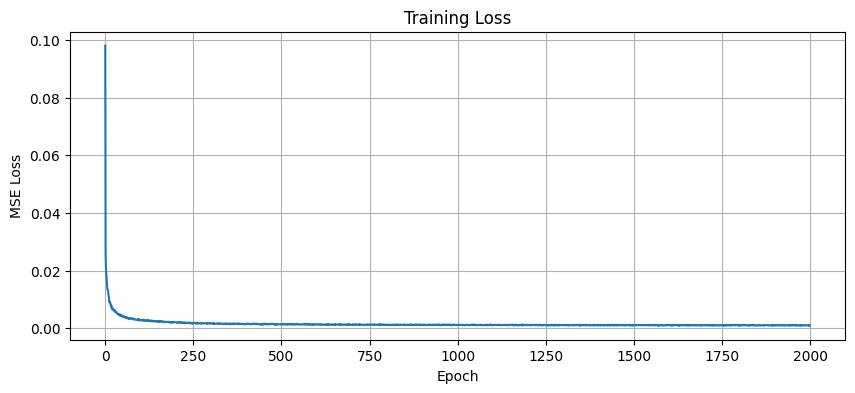

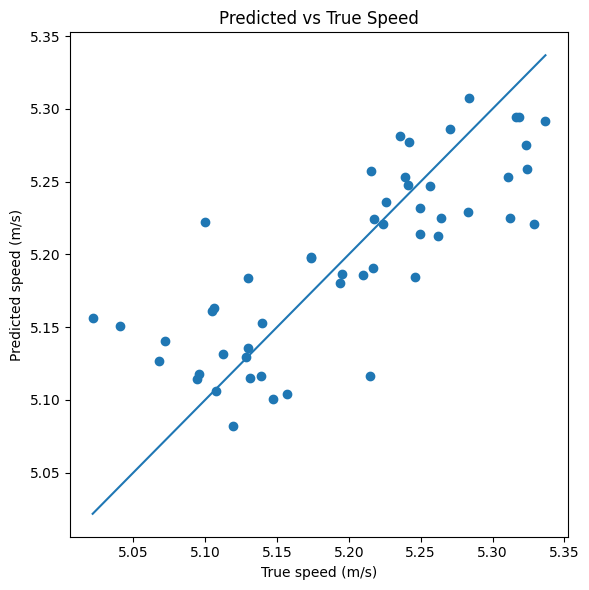

Number of data points: 1057
MSE: 0.0026
R2 score: 0.6270
MAPE: 0.77%
Split error over 500 m: 0.74 s


In [4]:

df_train = df.sample(frac=split)
df_test = df.drop(df_train.index)
X_train = df_train[feature_cols].values
y_train = (df_train[target_col] - w0).values.reshape(-1, 1)
X_test = df_test[feature_cols].values
y_test = df_test[target_col].values.reshape(-1, 1)

#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.dropout(self.relu(self.layer1(x)))
        x = self.dropout(self.relu(self.layer2(x)))
        x = self.dropout(self.relu(self.layer3(x)))
        x = self.layer4(x)
        return x

input_dim = X_train_scaled.shape[1]
model = RegressionNN(input_dim)

loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)  

loss_history = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = loss_func(outputs, y_batch)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    # Print progress every 50 epochs
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy() + w0
    y_true = y_test

plt.figure(figsize=(10, 4))
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

y_true_vals = y_true.flatten()
y_pred_vals = y_pred.flatten()


mse = mean_squared_error(y_true_vals, y_pred_vals)
r2 = r2_score(y_true_vals, y_pred_vals)

plt.figure(figsize=(6, 6))
plt.scatter(y_true_vals, y_pred_vals)
min_val = min(y_true_vals.min(), y_pred_vals.min())
max_val = max(y_true_vals.max(), y_pred_vals.max())
plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel('True speed (m/s)')
plt.ylabel('Predicted speed (m/s)')
plt.title('Predicted vs True Speed')
plt.tight_layout()
plt.show()

print(f'Number of data points: {len(df)}')
print(f'MSE: {mse:.4f}')
print(f'R2 score: {r2:.4f}')

# Calculate mean average percent error
pct_errors = (y_pred_vals - y_true_vals) / y_true_vals * 100
mape = np.mean(np.abs(pct_errors))
print(f"MAPE: {mape:.2f}%")

# Calculate 500m split time error
time_true = 500.0 / y_true_vals
time_pred = 500.0 / y_pred_vals
time_err = time_pred - time_true
mean_abs_time = np.mean(np.abs(time_err))
print(f"Split error over 500 m: {mean_abs_time:.2f} s")